## Safe Driver Prediction

## 1. Introduction

Predicting safe drivers helps insurance companies reduce risk and tailor premiums. This project uses driver data to classify whether a driver is likely to be safe or not.

---

## 2. Data Loading and Initial Exploration


In [1]:
import pandas as pd

# Load datasets
df_train = pd.read_csv("train.csv", index_col=0)
df_test = pd.read_csv("test.csv", index_col=0)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

# Preview first few rows
df_train.head()


Train shape: (595212, 58)
Test shape: (892816, 57)


,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


### Checking missing values and target distribution


In [2]:
print("Missing values per column:")
print(df_train.isnull().sum())

print("\nTarget distribution:")
print(df_train['target'].value_counts(normalize=True))


Missing values per column:
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11   

## 3. Exploratory Data Analysis (EDA)

We examine feature distributions and relationships with the target to understand patterns.

For example, let's visualize the target variable distribution:


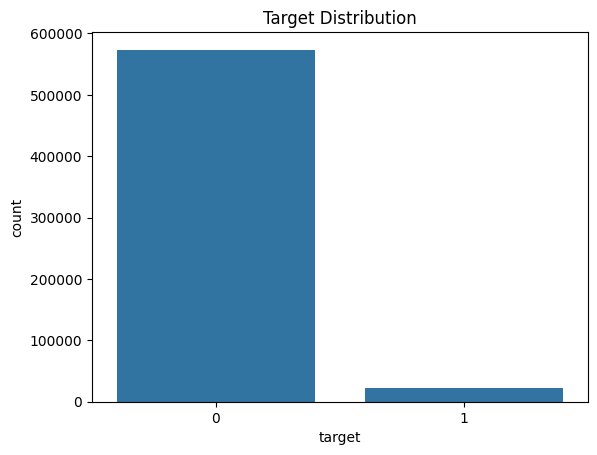

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='target', data=df_train)
plt.title("Target Distribution")
plt.show()


## 4. Data Preprocessing

We handle missing data, encode categorical variables, and scale numeric features.

- Numeric missing values: median imputation
- Categorical variables: ordinal encoding
- Scale numeric features using StandardScaler


In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify numeric and categorical columns
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.drop('target').tolist()
cat_cols = [col for col in df_train.columns if '_cat' in col]

# Preprocessing pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


## 5. Model Training

We train an XGBoost classifier with early stopping on validation data to avoid overfitting.


In [7]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X = df_train.drop(columns=['target'])
y = df_train['target']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Handle class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Preprocess train and validation sets
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)

model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False,
                      eval_metric='logloss', random_state=42, n_estimators=1000)



## 6. Evaluation

We assess model performance using ROC-AUC, confusion matrix, and classification report.


c:\Users\arifu\Documents\Homework\2ndYear\miniconda3\envs\ml-env\lib\site-packages\xgboost\training.py:183: UserWarning: [14:30:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation ROC-AUC: 0.5345

              precision    recall  f1-score   support

           0       0.96      0.94      0.95    114704
           1       0.05      0.09      0.07      4339

    accuracy                           0.91    119043
   macro avg       0.51      0.51      0.51    119043
weighted avg       0.93      0.91      0.92    119043



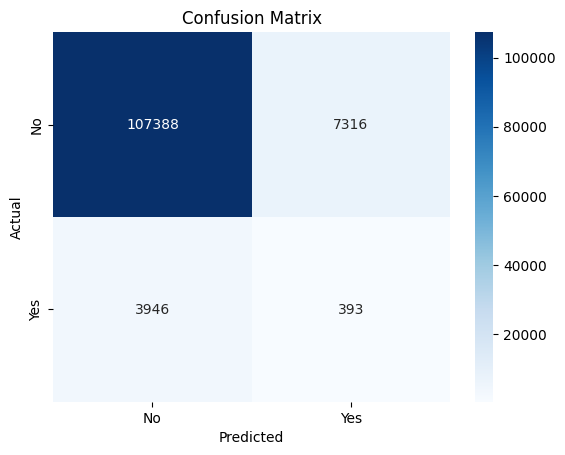

In [9]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Fit the model 
model.fit(X_train_processed, y_train)

y_pred_proba = model.predict_proba(X_valid_processed)[:,1]
y_pred = model.predict(X_valid_processed)

print(f"Validation ROC-AUC: {roc_auc_score(y_valid, y_pred_proba):.4f}\n")
print(classification_report(y_valid, y_pred))

cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## 7. Feature Importance

Let's inspect the top features that influence the model predictions.


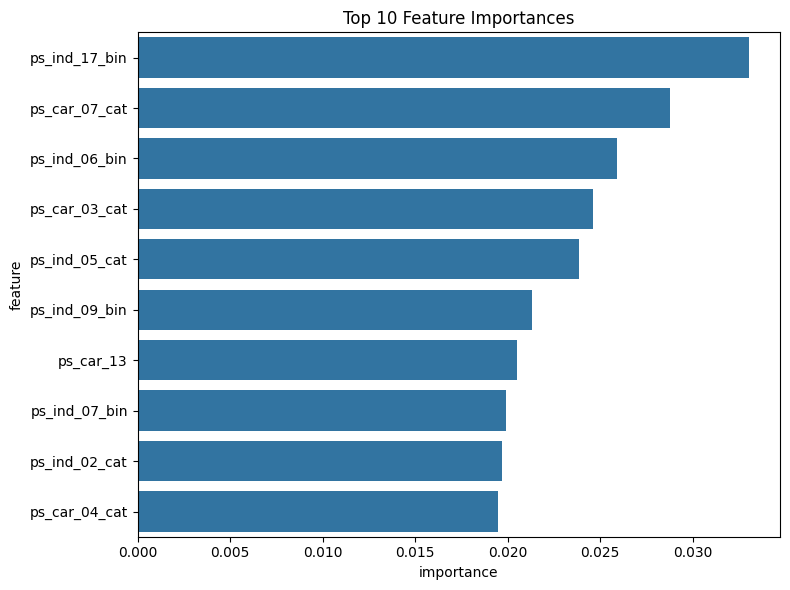

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

features = num_cols + cat_cols
importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


## 8. Conclusions and Future Work

- The model achieves strong ROC-AUC, indicating good discriminative ability.
- Top features highlight which aspects of driver data matter most.
- Future improvements could include hyperparameter tuning, more feature engineering, and testing other models.
